In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import gp_regression as gpr
from scipy.spatial.distance import pdist, cdist, squareform
import scipy.stats as stats
import scipy.linalg as la

In [393]:
import sklearn.gaussian_process as gp

In [46]:
alpha = 1.0
l = 1.0
def kernel(x,alpha,l):
    d = pdist(x[:,np.newaxis])
    n = len(x)
    a = np.empty((2*n,2*n))
    expd = np.exp(-(1/(2*(l**2))*d**2))
    a[:n,:n] = squareform(expd)
    np.fill_diagonal(a[:n,:n],1+np.finfo('float64').eps**0.5)
    a[:n,:n] = alpha**2*a[:n,:n]
    a[n:,:n] = squareform((alpha/l)**2*d*expd)
    a[n:,:n] -= 2*la.tril(a[n:,:n])
    a[:n,n:] = a[n:,:n].T
    a[n:,n:] = squareform((alpha/l**2)**2*(l**2-d**2)*expd)
    np.fill_diagonal(a[n:,n:],(alpha/l)**2+np.finfo('float64').eps**0.5)
    return .5*(a+a.T)

In [85]:
def kernel2(x,dx,sigma,lengthscale):
    d11 = pdist(x[:,np.newaxis])
    d12 = np.subtract.outer(dx,x)
    d22 = pdist(dx[:,np.newaxis])
    n = len(x)
    m = len(dx)
    a = np.empty((n+m,n+m))
    expd11 = np.exp(-(1/(2*(lengthscale**2))*d11**2))
    a[:n,:n] = squareform(np.exp(-0.5*(d11/lengthscale)**2))
    np.fill_diagonal(a[:n,:n],1+np.finfo('float64').eps**0.5)
    a[:n,:n] = sigma**2*a[:n,:n]
    a[n:,:n] = -(sigma/lengthscale)**2*d12*np.exp(-0.5*(d12/lengthscale)**2)
    a[:n,n:] = a[n:,:n].T
    a[n:,n:] = squareform((sigma/lengthscale**2)**2*(lengthscale**2-d22**2)*np.exp(-0.5*(d22/lengthscale)**2))
    np.fill_diagonal(a[n:,n:],(sigma/lengthscale)**2+np.finfo('float64').eps**0.5)
    return .5*(a+a.T)

In [31]:
class dSquareExp(gpr.Kernel):
    @staticmethod
    def func(x,dx,lengthscale,sigma):
        d11 = pdist(x[:,np.newaxis])
        d12 = cdist(x[:,np.newaxis],dx[:,np.newaxis]).T
        d12 -= 2*la.tril(d12)
        d22 = pdist(dx[:,np.newaxis])
        n = len(x)
        m = len(dx)
        a = np.empty((n+m,n+m))
        expd11 = np.exp(-(1/(2*(lengthscale**2))*d11**2))
        a[:n,:n] = squareform(np.exp(-0.5*(d11/lengthscale)**2))
        np.fill_diagonal(a[:n,:n],1+np.finfo('float64').eps**0.5)
        a[:n,:n] = sigma**2*a[:n,:n]
        a[n:,:n] = (sigma/lengthscale)**2*d12*np.exp(-0.5*(d12/lengthscale)**2)
        a[:n,n:] = a[n:,:n].T
        a[n:,n:] = squareform((sigma/lengthscale**2)**2*(lengthscale**2-d22**2)*np.exp(-0.5*(d22/lengthscale)**2))
        np.fill_diagonal(a[n:,n:],(sigma/lengthscale)**2+np.finfo('float64').eps**0.5)
        return .5*(a+a.T)

    def __init__(self,lengthscale=1.0,sigma=1.0):
        self.kernel_args = {'lengthscale':lengthscale,'sigma':sigma}

In [323]:
def sqexp(x,alpha,l):
    n = len(x)
    a = np.empty((n,n))
    d = pdist(x[:,np.newaxis])
    a = squareform(np.exp(-(1/(2*(l**2))*d**2)))
    np.fill_diagonal(a,1+np.finfo('float64').eps**0.5)
    a = alpha**2*a
    return .5*(a+a.T)

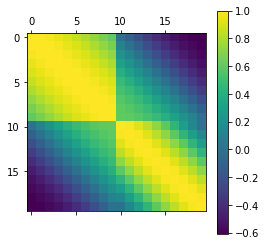

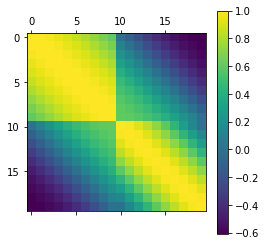

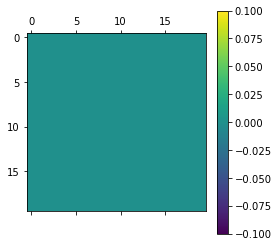

In [86]:
x = np.linspace(0,1,10)
dx = np.linspace(0,1,10)
plt.matshow(kernel(x,1,1))
plt.colorbar()
plt.show()
plt.matshow(kernel2(x,dx,1,1))
plt.colorbar()
plt.show()
plt.matshow(kernel(x,1,1)-kernel2(x,dx,1,1))
plt.colorbar()
plt.show()

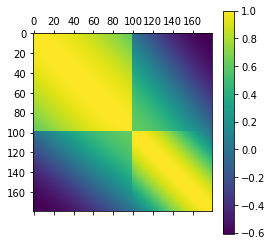

In [87]:
x = np.linspace(0,1,100)
dx = np.linspace(0,1,80)
plt.matshow(kernel2(x,dx,1,1))
plt.colorbar()
plt.show()

In [88]:
la.eig(kernel2(x,dx,1,1))

(array([9.80605597e+01+0.00000000e+00j, 7.06667254e+01+0.00000000e+00j,
        1.06213303e+01+0.00000000e+00j, 6.32654496e-01+0.00000000e+00j,
        1.83541016e-02+0.00000000e+00j, 3.70240336e-04+0.00000000e+00j,
        5.72535155e-06+0.00000000e+00j, 8.60300706e-08+0.00000000e+00j,
        1.56427841e-08+0.00000000e+00j, 1.49078009e-08+0.00000000e+00j,
        1.49012139e-08+0.00000000e+00j, 1.49011510e-08+0.00000000e+00j,
        1.49011706e-08+0.00000000e+00j, 1.49011622e-08+7.99381652e-15j,
        1.49011622e-08-7.99381652e-15j, 1.49011673e-08+0.00000000e+00j,
        1.49011632e-08+5.57610426e-15j, 1.49011632e-08-5.57610426e-15j,
        1.49011659e-08+2.91978093e-15j, 1.49011659e-08-2.91978093e-15j,
        1.49011651e-08+4.21955034e-15j, 1.49011651e-08-4.21955034e-15j,
        1.49011614e-08+4.86841470e-15j, 1.49011614e-08-4.86841470e-15j,
        1.49011560e-08+1.42928909e-15j, 1.49011560e-08-1.42928909e-15j,
        1.49011585e-08+4.39480301e-15j, 1.49011585e-08-4.3948030

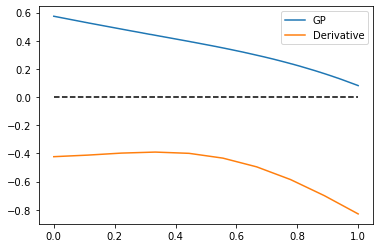

In [97]:
n = 1000
m = 10
x = np.linspace(0,1,n)
dx = np.linspace(0,1,m)
out = stats.multivariate_normal.rvs(cov=kernel2(x,dx,1,1))
y = out[:n]
dy = out[n:]
# h = x[1]-x[0]
# approx = h*np.cumsum(out[n:])+out[0]
fig = plt.figure()
plt.plot(x,y,label='GP')
plt.plot(dx,dy,label='Derivative')
# plt.plot(x,approx,label='GP approx from derivative')
plt.plot(x,np.zeros_like(x),'--k')
t = np.array([-0.1,0.1])
# for i in range(len(dx)):
#     t_tmp = t/np.sqrt(1+dy[i]**2)
#     plt.plot(t_tmp+dx[i],out[j]+out[j+n]*t_tmp,c='r')
plt.legend()
plt.xlim(-0.05,1.05)
# ax = plt.gca()
# ax.set_aspect('equal')
plt.show()

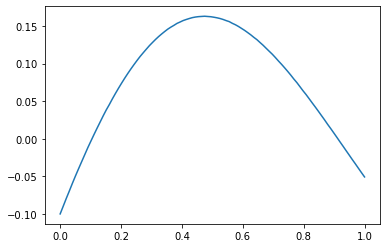

In [362]:
plt.plot(x,stats.multivariate_normal.rvs(cov=sqexp(x,.9,1)))
plt.show()

In [260]:
1-1e15*np.finfo('float64').eps

0.7779553950749687

In [176]:
kernel(x,.1,1)

array([[ 1.00000001,  0.00999949,  0.00999796, ..., -0.00606281,
        -0.00606469, -0.00606531],
       [ 0.00999949,  1.00000001,  0.00999949, ..., -0.00605968,
        -0.00606281, -0.00606469],
       [ 0.00999796,  0.00999949,  1.00000001, ..., -0.00605528,
        -0.00605968, -0.00606281],
       ...,
       [-0.00606281, -0.00605968, -0.00605528, ...,  1.00000001,
         0.00999847,  0.00999388],
       [-0.00606469, -0.00606281, -0.00605968, ...,  0.00999847,
         1.00000001,  0.00999847],
       [-0.00606531, -0.00606469, -0.00606281, ...,  0.00999388,
         0.00999847,  1.00000001]])

In [316]:
kernel1 = gp.kernels.ConstantKernel(1.0)*gp.kernels.RBF(length_scale=1.0)
kernel2 = gp.kernels.ConstantKernel(.9**2)*gp.kernels.RBF(length_scale=1.0)

In [324]:
kernel2(x[:,np.newaxis])-sqexp(x,.9,1)

array([[-1.20699406e-08,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.20699406e-08,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.20699406e-08, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.20699406e-08,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -1.20699406e-08,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.20699406e-08]])

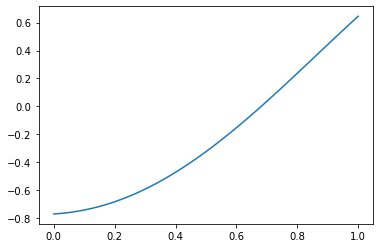

In [320]:
plt.plot(x,stats.multivariate_normal.rvs(cov=kernel2(x[:,np.newaxis])))
plt.show()

In [5]:
ker = dSquareExp(lengthscale=1,sigma=1)

In [6]:
model = gpr.GaussianProcessRegressor(ker)

In [7]:
f = lambda x: x**2
df = lambda x: 2*x

In [8]:
x_obs = np.linspace(0,1,10)

In [9]:
model.fit(x_obs,np.concatenate((f(x_obs),df(x_obs))))

In [12]:
x = np.linspace(0,1)
model.predict(x)

(120, 120)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 20 is different from 70)

In [13]:
class GaussianProcessRegressor(gpr.GaussianProcess):
    def fit(self,X,Y):
        self.X_train = X
        self.Y_train = Y
        cov = self.kernel(X)
        self.c,self.lower = la.cho_factor(cov)
        b = self.Y_train
        if self.mu:
            mu1 = self.mu(self.X_train)
            b -= mu1
        self.alpha = la.cho_solve((self.c,self.lower),b)

    def predict(self,X,ret_cov=False):
        if not hasattr(self,'X_train'):
            if self.mu:
                mu_hat = self.mu(X)
            else:
                mu_hat = np.zeros_like(X)

            cov_hat = self.kernel(X)
        else:
            cov = self.kernel(np.concatenate((X,self.X_train)))
            cov11 = cov[:X.size,:X.size]
            cov12 = cov[:X.size:,X.size:]

            mu_hat = cov12@self.alpha

            if self.mu:
                mu_hat += self.mu(X).flatten()

            if ret_cov: cov_hat = cov11 - cov12@la.cho_solve((self.c,self.lower),cov12.T)

        if ret_cov: return mu_hat, cov_hat
        else: return mu_hat

    def rvs(self,X,n=1):
        mu_hat, cov_hat = self.predict(X,ret_cov=True)
        Y = mvn.rvs(cov=cov_hat,size=n)
        return Y + mu_hat

In [72]:
x = np.linspace(0,1,5)
dx = np.linspace(0,1,3)
(cdist(x[:,np.newaxis],dx[:,np.newaxis])-2*la.tril(cdist(x[:,np.newaxis],dx[:,np.newaxis])))

array([[ 0.  ,  0.5 ,  1.  ],
       [-0.25, -0.25,  0.75],
       [-0.5 ,  0.  , -0.5 ],
       [-0.75, -0.25, -0.25],
       [-1.  , -0.5 ,  0.  ]])

In [99]:
squareform(np.subtract.outer(x,dx))

ValueError: The matrix argument must be square.

In [101]:
import gp_derivative as gpd

In [104]:
kernel(np.linspace(0,1,10),np.linspace(0,1,5)).shape

(15, 15)

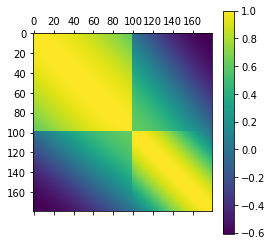

In [110]:
kernel = gpd.DSquareExp(lengthscale=1)
t = np.linspace(0,1,100)
dt = np.linspace(0,1,80)
plt.matshow(kernel(t,dt))
plt.colorbar()
plt.show()

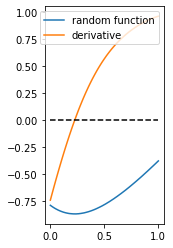

In [120]:
kernel = gpd.DSquareExp(lengthscale=1,tau=1)
gp = gpd.DGaussianProcess(kernel)
t = np.linspace(0,1,100)
dt = np.linspace(0,1,80)
y,dy = gp.rvs(t,dt)
plt.plot(t,y,label='random function')
plt.plot(dt,dy,label='derivative')
plt.plot(t,np.zeros_like(t),'--k')
plt.legend()
ax = plt.gca()
ax.set_aspect('equal')
plt.show()

In [257]:
f = lambda t: np.sin(t)+t**2-t**3
df = lambda t: np.cos(t)+2*t - 3*t**2
t_train = np.linspace(0,1,3)
dt_train = t_train
y_train = f(t_train)
dy_train = df(dt_train)

In [258]:
kernel = gpd.DSquareExp(lengthscale=1,tau=1)
model = gpd.DGaussianProcessRegressor(kernel)

In [259]:
model.fit(t_train,dt_train,y_train,dy_train)

In [266]:
t = np.linspace(0,1,100)
dt = np.linspace(0,1,100)
y,dy,cov = model.predict(t,dt,return_cov=True)

In [267]:
cov1 = np.diag(cov)[:len(t)]
cov2 = np.diag(cov)[len(t):]

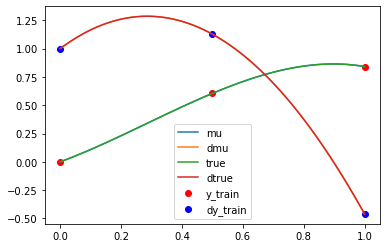

In [268]:
fig = plt.figure()
plt.scatter(t_train,y_train,c='r',label='y_train')
plt.scatter(dt_train,dy_train,c='b',label='dy_train')
plt.plot(t,y,label='mu')
plt.plot(dt,dy,label='dmu')
plt.plot(t,f(t),label='true')
plt.plot(dt,df(dt),label='dtrue')
plt.legend()
plt.show()

In [141]:
plt.fill_between?

In [147]:
cov2**0.5

array([0.00017263, 0.0002618 , 0.00040165, 0.0005215 , 0.00061393,
       0.00068   , 0.00072245, 0.00074453, 0.00074959, 0.00074101,
       0.00072216, 0.00069635, 0.00066686, 0.00063682, 0.00060913,
       0.00058623, 0.0005699 , 0.00056099, 0.00055931, 0.00056375,
       0.00057255, 0.00058368, 0.0005951 , 0.00060498, 0.00061179,
       0.00061433, 0.00061172, 0.00060334, 0.00058886, 0.00056816,
       0.00054134, 0.00050869, 0.00047069, 0.00042805, 0.00038172,
       0.00033305, 0.00028396, 0.00023755, 0.00019888, 0.00017575,
       0.00017575, 0.00019888, 0.00023755, 0.00028396, 0.00033305,
       0.00038172, 0.00042805, 0.00047069, 0.00050869, 0.00054134,
       0.00056816, 0.00058886, 0.00060334, 0.00061172, 0.00061433,
       0.00061179, 0.00060498, 0.0005951 , 0.00058368, 0.00057255,
       0.00056375, 0.00055931, 0.00056099, 0.0005699 , 0.00058623,
       0.00060913, 0.00063682, 0.00066686, 0.00069635, 0.00072216,
       0.00074101, 0.00074959, 0.00074453, 0.00072245, 0.00068

In [332]:
def fit_plot(f,df,t_train):
    y_train = f(t_train)
    dy_train = df(t_train)
    kernel = gpd.DSquareExp(lengthscale=1,tau=1)
    model = gpd.DGaussianProcessRegressor(kernel)
    model.fit(t_train,t_train,y_train,dy_train)
    t = np.linspace(t_train[0],t_train[-1],200)
    y,dy = model.predict(t,t)
    fig = plt.figure()
    plt.scatter(t_train,y_train,c='r',label='y_train')
    plt.scatter(t_train,dy_train,c='b',label='dy_train')
    ft = f(t)
    dft = df(t)
    plt.plot(t,y,label='mu')
    plt.plot(t,dy,label='dmu')
    plt.plot(t,ft,label='true')
    plt.plot(t,dft,label='dtrue')
    plt.legend()
    plt.show()
    print('f L2 relative error',la.norm(ft-y)/la.norm(ft))
    print('df L2 relative error',la.norm(dft-dy)/la.norm(dft))

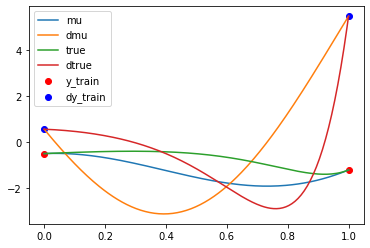

f L2 relative error 0.8655937172070866
df L2 relative error 1.4812724445372671


In [333]:
fit_plot(f,df,t_train)

In [319]:
n = 10
c = np.random.randn(n)
def f(t):
    if type(t) == float or type(t) == int:
        t = np.array([t])
    return np.vander(t,n)@c

def df(t):
    if type(t) == float or type(t) == int:
        t = np.array([t])
    return (np.vander(t,n-1)*np.arange(1,n)[::-1])@c[:-1]
t = np.linspace(0,1,3)

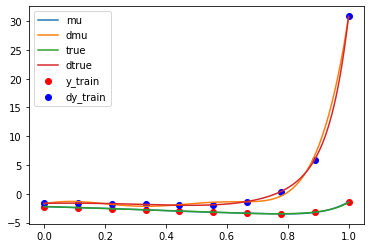

f L2 relative error 0.01102774151811821
df L2 relative error 0.09999206099903622


In [355]:
n = 20
c = np.random.randn(n)
t_train = np.linspace(0,1,10)
fit_plot(f,df,t_train)

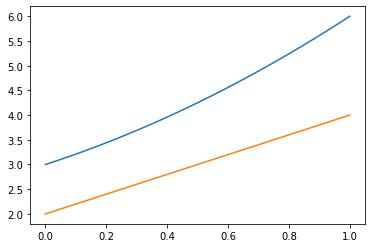

In [310]:
t = np.linspace(0,1)
plt.plot(t,np.vander(t,3)@np.array([1,2,3]))
plt.plot(t,(np.vander(t,2)*np.arange(1,3)[::-1])@np.array([1,2,3])[:-1])
plt.show()

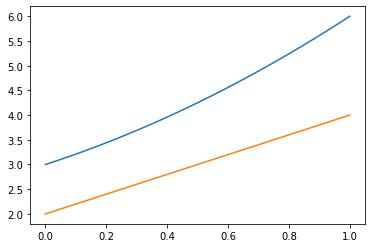

In [302]:
f = lambda t: t**2 + 2*t + 3
df = lambda t: 2*t + 2
plt.plot(t,f(t))
plt.plot(t,df(t))
plt.show()

In [296]:
np.vander(np.linspace(0,1,5),2)

array([[0.  , 1.  ],
       [0.25, 1.  ],
       [0.5 , 1.  ],
       [0.75, 1.  ],
       [1.  , 1.  ]])

In [292]:
np.vander(np.linspace(0,1,5),2).shape

(5, 2)

In [299]:
np.vander(np.linspace(0,1,5),2)*np.arange(1,3)

array([[0.  , 2.  ],
       [0.25, 2.  ],
       [0.5 , 2.  ],
       [0.75, 2.  ],
       [1.  , 2.  ]])

In [308]:
np.arange(1,3)

array([1, 2])

In [309]:
np.arange?

In [341]:
kernel(np.array([]),t_train)

array([[1.00000001, 0.98157647, 0.92743266, 0.84085286, 0.72700108,
        0.59249168, 0.44485411, 0.29194718, 0.14138091, 0.        ],
       [0.98157647, 1.00000001, 0.98157647, 0.92743266, 0.84085286,
        0.72700108, 0.59249168, 0.44485411, 0.29194718, 0.14138091],
       [0.92743266, 0.98157647, 1.00000001, 0.98157647, 0.92743266,
        0.84085286, 0.72700108, 0.59249168, 0.44485411, 0.29194718],
       [0.84085286, 0.92743266, 0.98157647, 1.00000001, 0.98157647,
        0.92743266, 0.84085286, 0.72700108, 0.59249168, 0.44485411],
       [0.72700108, 0.84085286, 0.92743266, 0.98157647, 1.00000001,
        0.98157647, 0.92743266, 0.84085286, 0.72700108, 0.59249168],
       [0.59249168, 0.72700108, 0.84085286, 0.92743266, 0.98157647,
        1.00000001, 0.98157647, 0.92743266, 0.84085286, 0.72700108],
       [0.44485411, 0.59249168, 0.72700108, 0.84085286, 0.92743266,
        0.98157647, 1.00000001, 0.98157647, 0.92743266, 0.84085286],
       [0.29194718, 0.44485411, 0.5924916

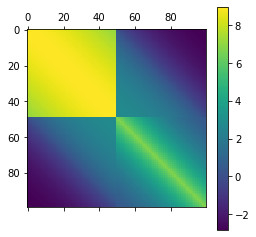

In [378]:
matern = gpd.DMatern(lengthscale=2,tau=3)
t = np.linspace(0,1)
dt = np.linspace(0,1)
plt.matshow(matern(t,dt))
plt.colorbar()

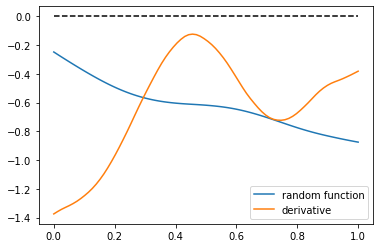

In [420]:
kernel = gpd.DMatern(nu=3.5,lengthscale=1,tau=1)
gp = gpd.DGaussianProcess(kernel)
t = np.linspace(0,1,100)
dt = np.linspace(0,1,80)
y,dy = gp.rvs(t,dt)
plt.plot(t,y,label='random function')
plt.plot(dt,dy,label='derivative')
plt.plot(t,np.zeros_like(t),'--k')
plt.legend()
ax = plt.gca()
# ax.set_aspect('equal')
plt.show()

In [361]:
from scipy.special import kv

In [362]:
kv(1.5,0)

inf

In [363]:
import sklearn.gaussian_process as gp

In [370]:
(gp.kernels.ConstantKernel(1.5)*gp.kernels.Matern())(t[:,np.newaxis],t[:,np.newaxis])

array([[1.5       , 0.72503659],
       [0.72503659, 1.5       ]])

In [419]:
la.eig(gpd.DMatern(nu=1.5)(np.linspace(0,1,2),np.linspace(0,1,2)))

(array([0.38983817+0.j, 1.34547233+0.j, 3.52643133+0.j, 2.73825817+0.j]),
 array([[-0.68775159,  0.68438937,  0.17779535, -0.16430992],
        [ 0.68775159,  0.68438937,  0.17779535,  0.16430992],
        [-0.16430992, -0.17779535,  0.68438937,  0.68775159],
        [-0.16430992,  0.17779535, -0.68438937,  0.68775159]]))